In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image

In [2]:
path2test="/content/drive/MyDrive/Colab_Notebooks/Computer_Vision_02/04_Single_Object_Segmentation/Data /test_set"
imgsList=[pp for pp in os.listdir(path2test) if "Annotation" not in pp]
print("number of images:", len(imgsList))

number of images: 336


array(['217_2HC.png', '322_HC.png', '193_HC.png', '105_3HC.png'],
      dtype='<U11')

In [4]:
class SegNet(nn.Module):
    def __init__(self, params):
      super(SegNet, self).__init__()
      C_in, H_in, W_in=params["input_shape"]
      init_f=params["initial_filters"]
      num_outputs=params["num_outputs"]
      self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
      self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
      self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
      self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
      self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)
      self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
      self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
      self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
      self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)
      self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv4(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv5(x))
      x=self.upsample(x)
      x = F.relu(self.conv_up1(x))
      x=self.upsample(x)
      x = F.relu(self.conv_up2(x))
      x=self.upsample(x)
      x = F.relu(self.conv_up3(x))
      x=self.upsample(x)
      x = F.relu(self.conv_up4(x))
      x = self.conv_out(x)
      return x

In [5]:
h,w=128,192
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16,
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [9]:
def show_img_mask(img, mask):
  img_mask=mark_boundaries(np.array(img),
                      np.array(mask),
                      outline_color=(0,1,0),
                      color=(0,1,0))
  plt.imshow(img_mask)

In [10]:
path2weights="/content/drive/MyDrive/Colab_Notebooks/Computer_Vision_02/04_Single_Object_Segmentation/Modelsweights.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

<ipython-input-19-0e7c11a82646>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(mask_pred).cpu(), cmap="gray")
<ipython-input-19-0e7c11a82646>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  show_img_mask(img,torch.tensor(mask_pred).cpu())


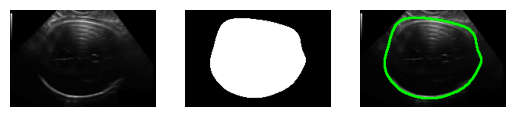

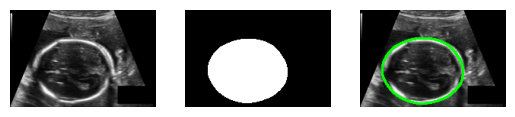

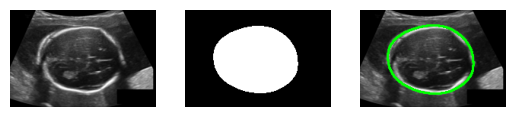

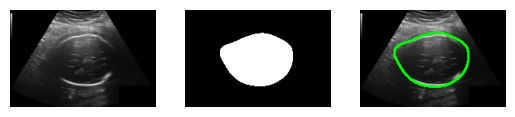

In [19]:
rndImgs=np.random.choice(imgsList,4)
rndImgs
for fn in rndImgs:
  path2img = os.path.join(path2test, fn)
  img = Image.open(path2img)
  img=img.resize((w,h))
  img_t=to_tensor(img).unsqueeze(0).to(device)

  pred=model(img_t)
  pred=torch.sigmoid(pred)[0]
  mask_pred= (pred[0]>=0.5)

  plt.figure()
  plt.subplot(1, 3, 1)
  plt.imshow(img, cmap="gray")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(torch.tensor(mask_pred).cpu(), cmap="gray")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  show_img_mask(img,torch.tensor(mask_pred).cpu())
  plt.axis("off")